In [945]:
#!/usr/bin/env python3

1. Introduction

##### Datasegments used | Description 

- id - identifier
- segment_id - segment identifier
- tine_index - timestamp of hour aggregation
- devices - on which devices these views were generated

Dataset Description
|segment_id   |  segment_name |
|---|---|
|00052 |Travel   |
|00053 |Style & Fashion   |
|00058   |Shopping   |
|00077   |Pets   |
|00090   |Sports   |
|00150   |Science   |
|00176   |Religion & Spirituality   |
|00210   |Sensitive Topics   |
|00274   |Music   |
|00279   |Food & Drink   |
|00379   |Technology & Computing   |
|00483   |Books and Literature   |
|00492   |Real Estate   |

##### Libraries used

In [946]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import json
import seaborn as sns
from pylab import rcParams
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot


dataPoints = pd.read_csv('datapoints-ssp-mock2.csv') # datapoints spreadsheet in csv format
segments = pd.read_csv('segments-ssp-mock2.csv') # segments spreadsheet in csv format

In [947]:
# lets focus on first five rows
dataPoints.head() 

,id,segment_id,time_index,view_count,devices
0,1,379,2022-01-01 00:00:00,177,"{""windows"": 120, ""android"": 7, ""mac os x"": 37,..."
1,2,379,2022-01-01 01:00:00,135,"{""windows"": 92, ""android"": 5, ""mac os x"": 28, ..."
2,3,379,2022-01-01 02:00:00,26,"{""windows"": 18, ""android"": 1, ""mac os x"": 5, ""..."
3,4,379,2022-01-01 03:00:00,159,"{""windows"": 108, ""android"": 6, ""mac os x"": 33,..."
4,5,379,2022-01-01 04:00:00,50,"{""windows"": 34, ""android"": 2, ""mac os x"": 10, ..."


In [948]:
segments.head()

,segment_id,segment_name
0,52,Travel
1,53,Style & Fashion
2,58,Shopping
3,77,Pets
4,90,Sports


In [949]:
# checks null values
dataPoints.isnull().values.any()

False

In [950]:
#  indexing 'id' as row labels for dataframe
indexed_dataPoints = dataPoints.set_index('id')
indexed_dataPoints.head()

,segment_id,time_index,view_count,devices
id,,,,
1,379,2022-01-01 00:00:00,177,"{""windows"": 120, ""android"": 7, ""mac os x"": 37,..."
2,379,2022-01-01 01:00:00,135,"{""windows"": 92, ""android"": 5, ""mac os x"": 28, ..."
3,379,2022-01-01 02:00:00,26,"{""windows"": 18, ""android"": 1, ""mac os x"": 5, ""..."
4,379,2022-01-01 03:00:00,159,"{""windows"": 108, ""android"": 6, ""mac os x"": 33,..."
5,379,2022-01-01 04:00:00,50,"{""windows"": 34, ""android"": 2, ""mac os x"": 10, ..."


In [951]:
indexed_dataPoints.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95526 entries, 1 to 95526
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   segment_id  95526 non-null  int64 
 1   time_index  95526 non-null  object
 2   view_count  95526 non-null  int64 
 3   devices     95526 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.6+ MB


In [952]:
#  converted JSON string to Python object
indexed_dataPoints['devices'] = indexed_dataPoints['devices'].apply(json.loads)

# new DataFrame with individual device columns
devices_df = pd.DataFrame(indexed_dataPoints['devices'].tolist(), index=indexed_dataPoints.index)

# new DataFrame with the original main_dataset
new_dataset = pd.concat([indexed_dataPoints[['segment_id', 'time_index', 'view_count']], devices_df], axis=1)



In [953]:
new_dataset

,segment_id,time_index,view_count,windows,android,mac os x,iphone,other
id,,,,,,,,
1,379,2022-01-01 00:00:00,177,120,7,37,9,2
2,379,2022-01-01 01:00:00,135,92,5,28,7,1
3,379,2022-01-01 02:00:00,26,18,1,5,1,0
4,379,2022-01-01 03:00:00,159,108,6,33,8,2
5,379,2022-01-01 04:00:00,50,34,2,10,2,0
...,...,...,...,...,...,...,...,...
95522,77,2022-11-27 01:00:00,240,110,12,94,19,5
95523,77,2022-11-27 02:00:00,242,111,12,94,19,5
95524,77,2022-11-27 03:00:00,207,95,10,81,17,4


In [954]:
# merged with segments dataset, renamed columns
final_dataset = pd.merge(new_dataset, segments, on='segment_id', how='left')
final_dataset.rename(columns={
    'segment_id': 'ID Segment',
    'time_index': 'View Date',
    'view_count': 'Number of Views',
    'windows': 'Windows Device',
    'android': 'Android Device',
    'mac os x': 'Mac OS X Device',
    'iphone': 'Iphone Device',
    'other': 'Other Device',
    'segment_name': 'Segment Name'
}, inplace=True)
final_dataset.head()

,ID Segment,View Date,Number of Views,Windows Device,Android Device,Mac OS X Device,Iphone Device,Other Device,Segment Name
0,379,2022-01-01 00:00:00,177,120,7,37,9,2,Technology & Computing
1,379,2022-01-01 01:00:00,135,92,5,28,7,1,Technology & Computing
2,379,2022-01-01 02:00:00,26,18,1,5,1,0,Technology & Computing
3,379,2022-01-01 03:00:00,159,108,6,33,8,2,Technology & Computing
4,379,2022-01-01 04:00:00,50,34,2,10,2,0,Technology & Computing


In [955]:
columns = ['ID Segment', 'View Date', 'Number of Views', 'Windows Device', 'Android Device', 'Mac OS X Device', 'Iphone Device', 'Other Device', 'Segment Name']
df = pd.DataFrame(final_dataset, columns=columns)

# Sort the DataFrame by 'Windows Device' column in descending order
sorted_df = df.sort_values(by='Windows Device', ascending=False)

# Get the top 3 segments with the highest number of views from Windows devices
top_windows_segments = sorted_df.head(3)['Segment Name'].tolist()
print(top_windows_segments)

['Technology & Computing', 'Technology & Computing', 'Technology & Computing']


2.  Overview - Basic statistics.

a) Number of views per segment

The majority of views are related to technology and computing, style and fashion, and travel.

In [956]:
views_by_segment = pd.DataFrame(final_dataset.groupby('Segment Name')['Number of Views'].sum())
views_by_segment.sort_values(by='Number of Views', ascending=False)


,Number of Views
Segment Name,
Technology & Computing,28744214
Style & Fashion,19358950
Travel,19085463
Sports,17948917
Shopping,15504879
Books and Literature,6079332
Science,3910647
Religion & Spirituality,3902934
Real Estate,2672780


b) Average, median number and total sum of views per segment.


Mean: The average number of views for each segment.

Median: The middle value in a sorted list of the number of views for each segment.

Sum: The total number of views for each segment.

In [957]:
summary = final_dataset.pivot_table(values='Number of Views', index='Segment Name', aggfunc=[np.mean, np.median, np.sum])
summary_df = pd.DataFrame(summary)

# Display the DataFrame
summary_df


,mean,median,sum
,Number of Views,Number of Views,Number of Views
Segment Name,,,
Books and Literature,693.987671,650.5,6079332
Pets,148.435024,125.0,1176496
Real Estate,305.111872,280.0,2672780
Religion & Spirituality,445.540411,408.0,3902934
Science,446.420890,414.0,3910647
Sensitive Topics,203.652283,184.0,1783994
Shopping,1769.963356,1645.0,15504879
Sports,2048.963128,1922.5,17948917


c) Average number of views by Segment

Technology & Computing     3281.302968

Style & Fashion            2209.925799

Travel                     2178.705822

In [958]:
average_views_by_segment = final_dataset.groupby('Segment Name')['Number of Views'].mean().sort_values(ascending=False)
print("Average Views by Segment:\n", average_views_by_segment)

Average Views by Segment:
 Segment Name
Technology & Computing     3281.302968
Style & Fashion            2209.925799
Travel                     2178.705822
Sports                     2048.963128
Shopping                   1769.963356
Books and Literature        693.987671
Science                     446.420890
Religion & Spirituality     445.540411
Real Estate                 305.111872
Sensitive Topics            203.652283
Pets                        148.435024
Name: Number of Views, dtype: float64


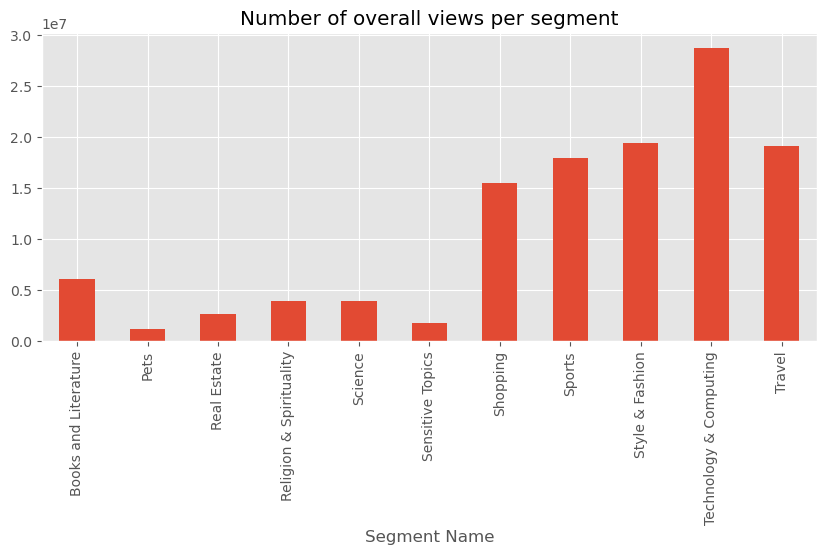

In [959]:
nb_views_per_segment = final_dataset.groupby('Segment Name')['Number of Views'].sum()
nb_views_per_segment.plot(kind='bar', title='Number of overall views per segment')
plt.show()

d) Overall average views for each device type.

Overall Average Views by Device Type:
|                 	| Overall Average Views 	|
|-----------------	|-----------------------	|
| Windows Device  	| 858.271898            	|
| Mac OS X Device 	| 259.819775            	|
| Iphone Device   	| 60.055967             	|
| Android Device  	| 47.301066             	|
| Other Device    	| 13.525041             	|


------------------------------------------------------------
Average Views by Device Type:



| Segment Name            	| Windows Device 	| Android Device 	| Mac OS X Device 	| Iphone Device 	| Other Device 	|
|-------------------------	|----------------	|----------------	|-----------------	|---------------	|--------------	|
| Books and Literature    	| 464.969977     	| 27.760845      	| 152.682763      	| 34.697374     	| 13.883219    	|
| Pets                    	| 68.283119      	| 7.426571       	| 57.896291       	| 11.878880     	| 2.960384     	|
| Real Estate             	| 183.066667     	| 15.251484      	| 82.378082       	| 18.309018     	| 6.102740     	|
| Religion & Spirituality 	| 343.068836     	| 8.905594       	| 71.286416       	| 13.368607     	| 4.450913     	|
| Science                 	| 339.276484     	| 8.924429       	| 75.896918       	| 13.390868     	| 4.459932     	|
| Sensitive Topics        	| 118.114612     	| 10.179110      	| 61.097260       	| 12.223059     	| 2.024315     	|
| Shopping                	| 1274.373744    	| 53.097146      	| 336.294749      	| 70.801256     	| 17.705365    	|
| Sports                  	| 1434.275799    	| 81.961644      	| 409.797032      	| 102.450228    	| 20.487785    	|
| Style & Fashion         	| 1502.749543    	| 88.398744      	| 464.086758      	| 110.499087    	| 22.103995    	|
| Technology & Computing  	| 2231.290411    	| 131.254338     	| 689.071575      	| 164.062329    	| 32.813699    	|
| Travel                  	| 1481.521689    	| 87.151826      	| 457.529680      	| 108.934932    	| 21.783105    	|


Most Popular Segment per Device:
- Technology and computing

In [960]:
device_columns = ['Windows Device', 'Android Device', 'Mac OS X Device', 'Iphone Device', 'Other Device']
average_views_by_device = final_dataset.groupby('Segment Name')[device_columns].mean()

# The overall average views for each device type
overall_average_views_by_device = average_views_by_device.mean().sort_values(ascending=False)
overall_average_df = pd.DataFrame(overall_average_views_by_device, columns=['Overall Average Views'])

print("Overall Average Views by Device Type:\n", overall_average_df,'\n')

final_dataset['Total Devices'] = final_dataset[device_columns].sum(axis=1)

# The average number of views for each device type
average_views_by_device = final_dataset.groupby('Segment Name')[device_columns].mean()
print("Average Views by Device Type:\n", average_views_by_device)


Overall Average Views by Device Type:
                  Overall Average Views
Windows Device              858.271898
Mac OS X Device             259.819775
Iphone Device                60.055967
Android Device               47.301066
Other Device                 13.525041 

Average Views by Device Type:
                          Windows Device  Android Device  Mac OS X Device  \
Segment Name                                                               
Books and Literature         464.969977       27.760845       152.682763   
Pets                          68.283119        7.426571        57.896291   
Real Estate                  183.066667       15.251484        82.378082   
Religion & Spirituality      343.068836        8.905594        71.286416   
Science                      339.276484        8.924429        75.896918   
Sensitive Topics             118.114612       10.179110        61.097260   
Shopping                    1274.373744       53.097146       336.294749   
Sports    

In [961]:
segment_average_views = final_dataset.groupby('Segment Name')['Number of Views'].mean()

# The most popular segment index for each device type
device_columns = ['Windows Device', 'Android Device', 'Mac OS X Device', 'Iphone Device', 'Other Device']
most_popular_segment_indices = {device: segment_average_views.idxmax() for device in device_columns}

# Create a DataFrame to display the most popular segment per device
most_popular_segment_df = pd.DataFrame(most_popular_segment_indices.items(), columns=['Device', 'Most Popular Segment'])
print("Most Popular Segment per Device:\n", most_popular_segment_df)

Most Popular Segment per Device:
             Device    Most Popular Segment
0   Windows Device  Technology & Computing
1   Android Device  Technology & Computing
2  Mac OS X Device  Technology & Computing
3    Iphone Device  Technology & Computing
4     Other Device  Technology & Computing


3. Seasonality observation which can affect the segments when it comes to views.

In [962]:
final_dataset.head(n=25)

,ID Segment,View Date,Number of Views,Windows Device,Android Device,Mac OS X Device,Iphone Device,Other Device,Segment Name,Total Devices
0,379,2022-01-01 00:00:00,177,120,7,37,9,2,Technology & Computing,175
1,379,2022-01-01 01:00:00,135,92,5,28,7,1,Technology & Computing,133
2,379,2022-01-01 02:00:00,26,18,1,5,1,0,Technology & Computing,25
3,379,2022-01-01 03:00:00,159,108,6,33,8,2,Technology & Computing,157
4,379,2022-01-01 04:00:00,50,34,2,10,2,0,Technology & Computing,48
5,379,2022-01-01 05:00:00,164,112,7,34,8,2,Technology & Computing,163
6,379,2022-01-01 06:00:00,24,16,1,5,1,0,Technology & Computing,23
7,379,2022-01-01 07:00:00,246,167,10,52,12,2,Technology & Computing,243
8,379,2022-01-01 08:00:00,462,314,18,97,23,5,Technology & Computing,457
9,379,2022-01-01 09:00:00,351,239,14,74,18,4,Technology & Computing,349


#### We need to convert View Date column to a datetime format.

In [963]:
final_dataset['View Date'] = pd.to_datetime(final_dataset['View Date'])

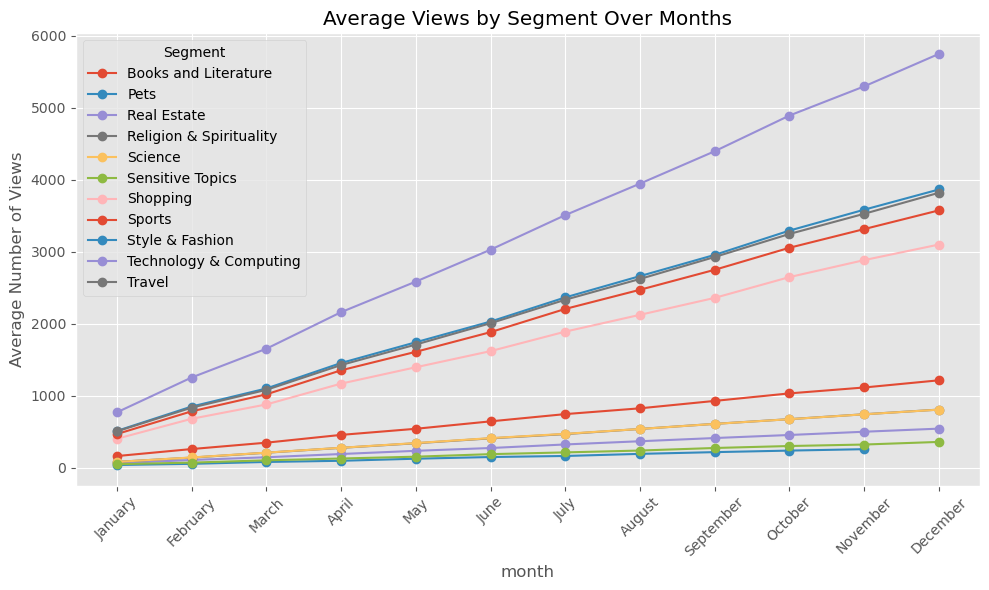

In [964]:
# new column month
final_dataset['month'] = final_dataset['View Date'].dt.month
average_views_by_month = final_dataset.groupby(['Segment Name', 'month'])['Number of Views'].mean().reset_index()
pivot_table = average_views_by_month.pivot(index='month', columns='Segment Name', values='Number of Views')

pivot_table

# Plot the average views for each segment
pivot_table.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Average Views by Segment Over Months')
plt.xlabel('month')
plt.ylabel('Average Number of Views')
plt.legend(title='Segment')
plt.xticks(range(1, 13), calendar.month_name[1:], rotation=45)
plt.tight_layout()
plt.show()

In [965]:
final_dataset['day_of_week'] = final_dataset['View Date'].dt.day_of_week
final_dataset['day_of_month'] = final_dataset['View Date'].dt.day
final_dataset['month'] = final_dataset['View Date'].dt.month
final_dataset['hour'] = final_dataset['View Date'].dt.hour

final_dataset.sample(5)

,ID Segment,View Date,Number of Views,Windows Device,Android Device,Mac OS X Device,Iphone Device,Other Device,Segment Name,Total Devices,month,day_of_week,day_of_month,hour
9697,52,2022-02-09 01:00:00,584,397,23,123,29,6,Travel,578,2,2,9,1
81215,492,2022-04-09 23:00:00,174,104,9,47,10,3,Real Estate,173,4,5,9,23
92937,77,2022-08-11 09:00:00,184,85,9,72,15,4,Pets,185,8,3,11,9
83393,492,2022-07-09 17:00:00,310,186,16,84,19,6,Real Estate,311,7,5,9,17
60360,210,2022-11-22 00:00:00,310,180,16,93,19,3,Sensitive Topics,311,11,1,22,0


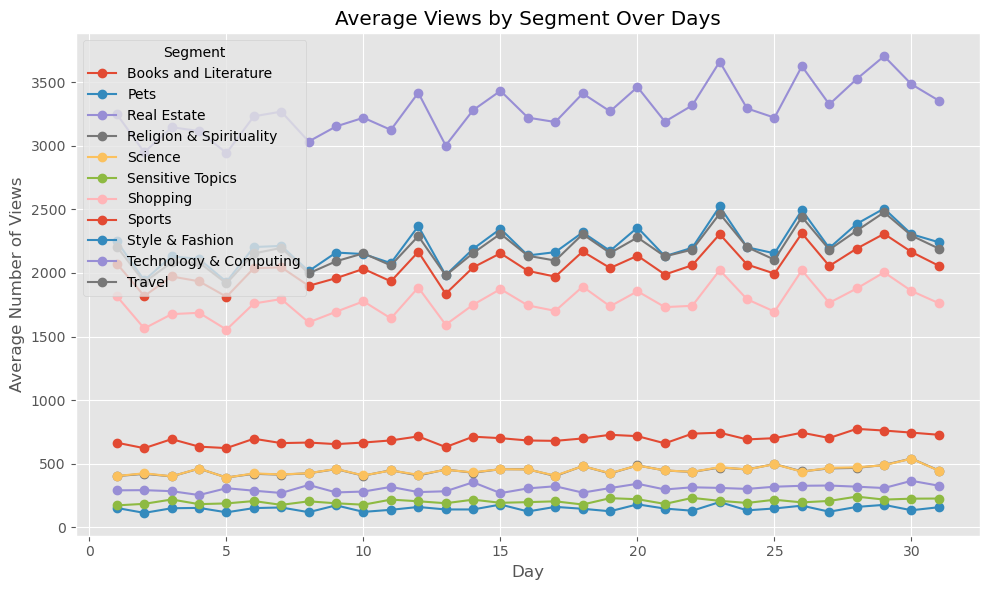

In [966]:
# Create a new column for the day
final_dataset['Day'] = final_dataset['View Date'].dt.day

# Calculate average views for each segment on each day
average_views_by_day = final_dataset.groupby(['Segment Name', 'Day'])['Number of Views'].mean().reset_index()

# Create a pivot table for easy plotting
pivot_table = average_views_by_day.pivot(index='Day', columns='Segment Name', values='Number of Views')

# Plot the average views for each segment
pivot_table.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Average Views by Segment Over Days')
plt.xlabel('Day')
plt.ylabel('Average Number of Views')
plt.legend(title='Segment')
plt.tight_layout()
plt.show()

In [967]:
final_dataset.isnull().values.any()

False

Segment: Books and Literature
Low Months: January, February, March, April, May
------
Segment: Pets
Low Months: January, February, March, April, May
------
Segment: Real Estate
Low Months: January, February, March, April, May
------
Segment: Religion & Spirituality
Low Months: January, February, March, April, May
------
Segment: Science
Low Months: January, February, March, April, May
------
Segment: Sensitive Topics
Low Months: January, February, March, April, May
------
Segment: Shopping
Low Months: January, February, March, April, May, June
------
Segment: Sports
Low Months: January, February, March, April, May, June
------
Segment: Style & Fashion
Low Months: January, February, March, April, May, June
------
Segment: Technology & Computing
Low Months: January, February, March, April, May, June
------
Segment: Travel
Low Months: January, February, March, April, May, June
------


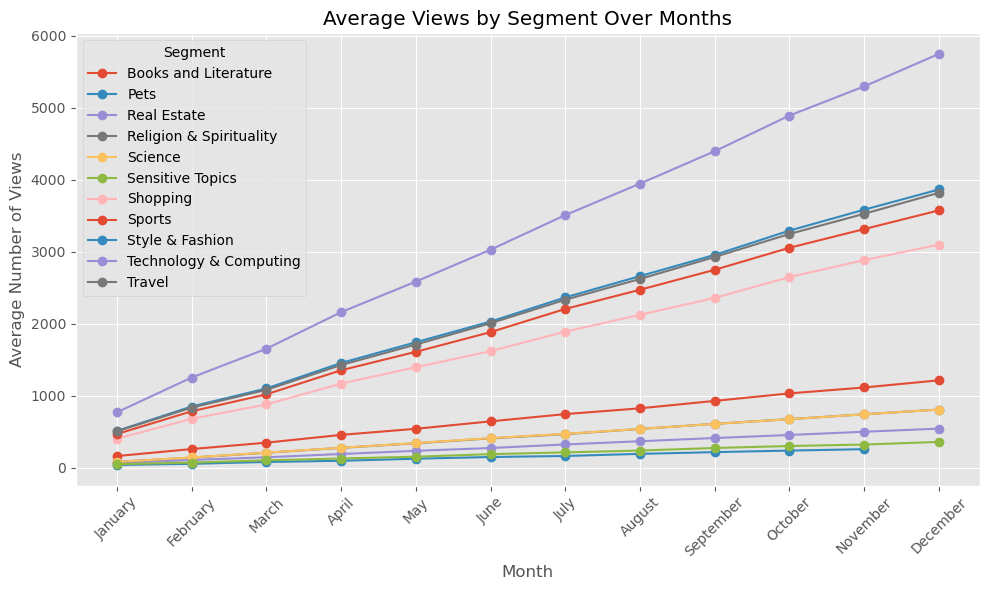

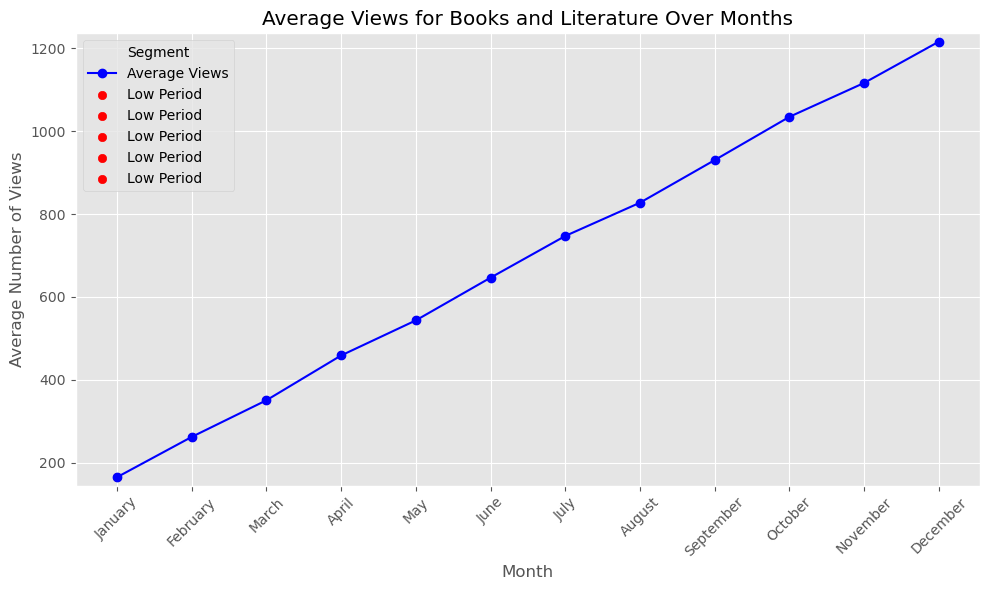

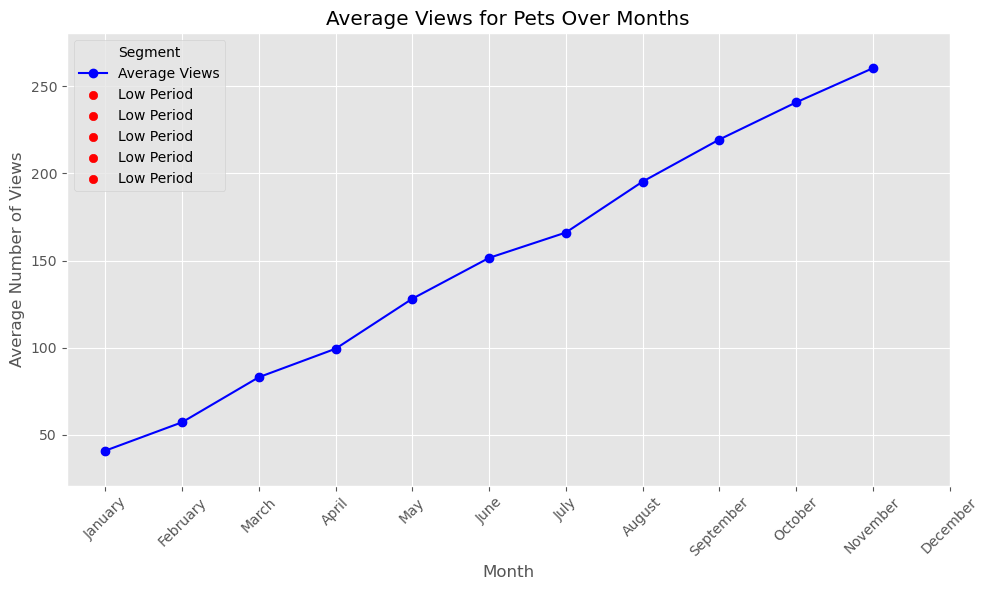

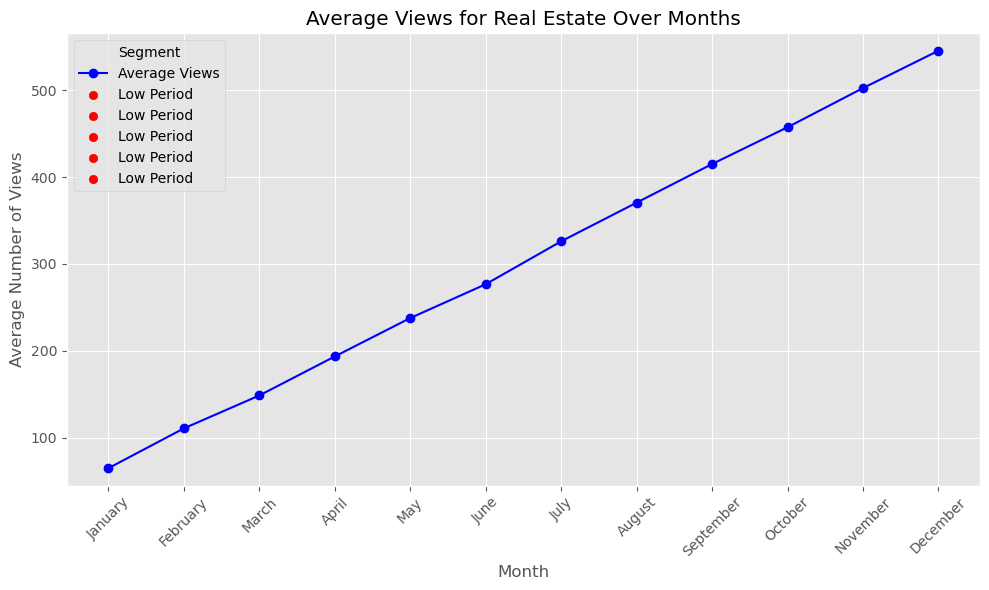

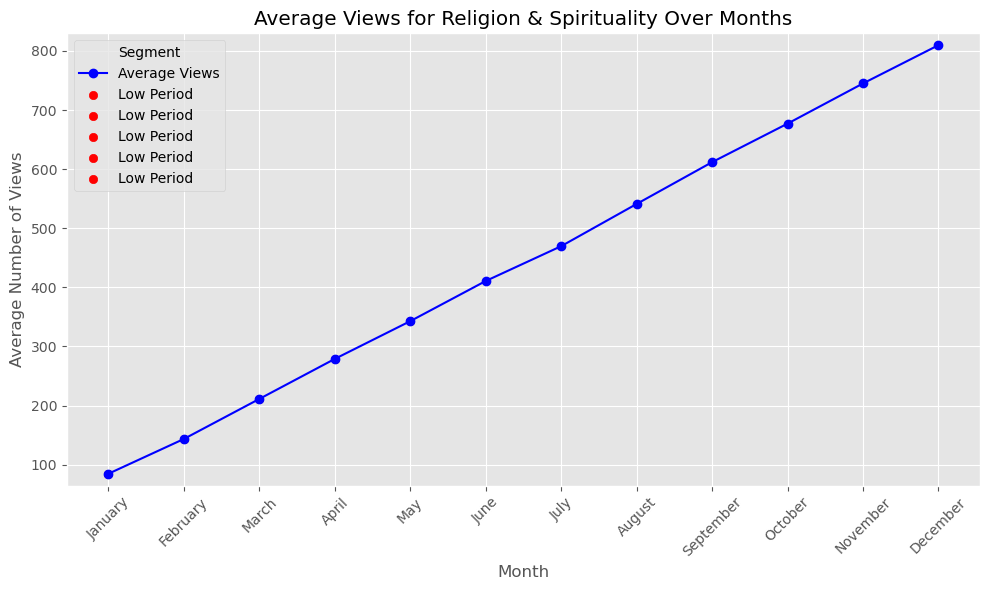

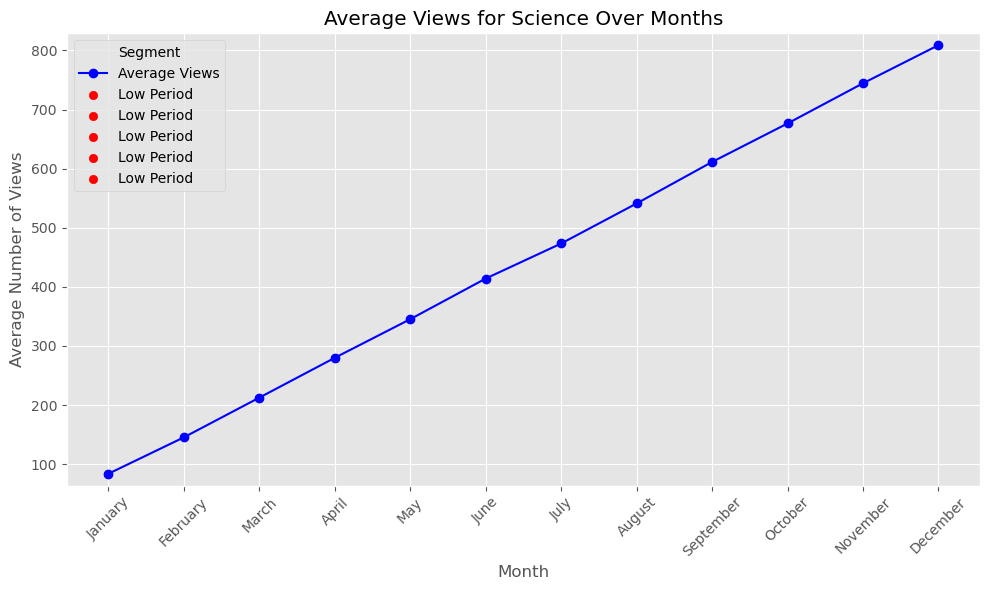

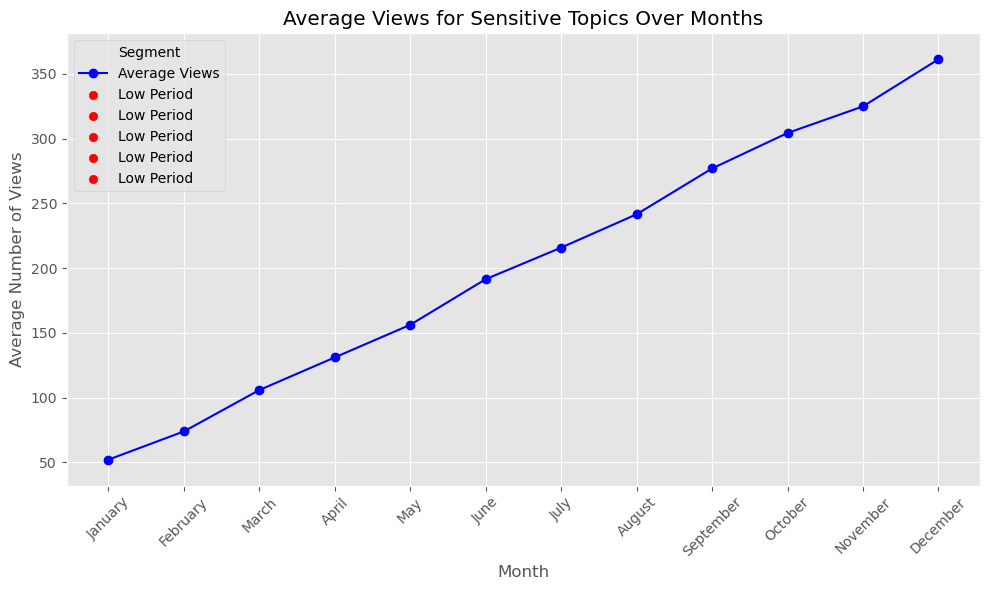

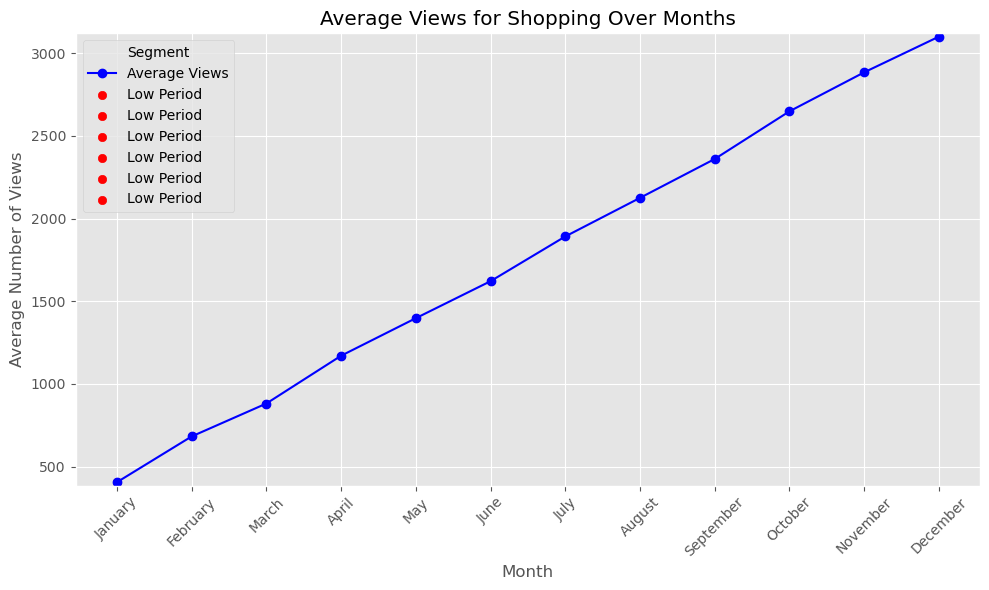

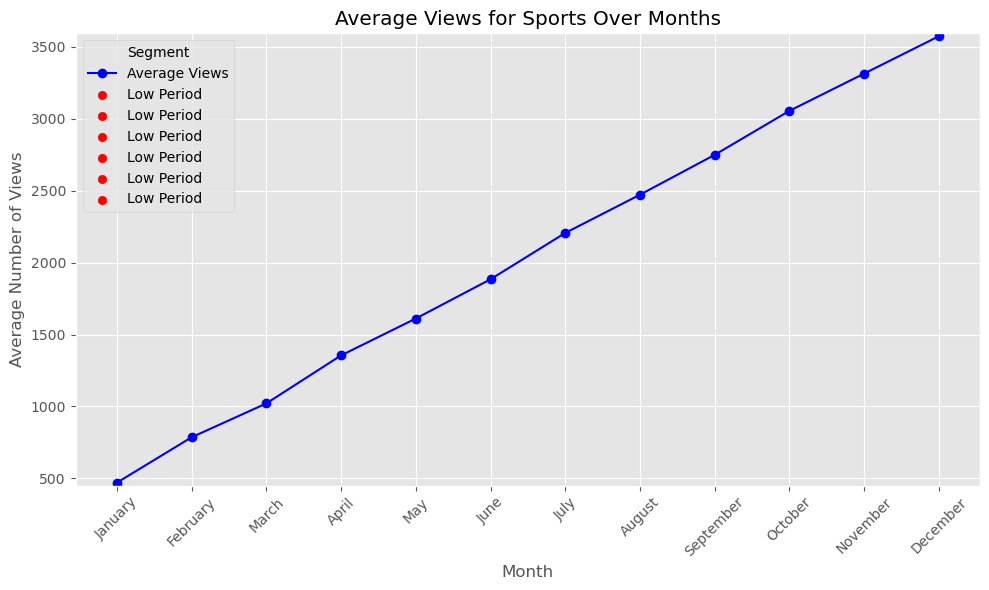

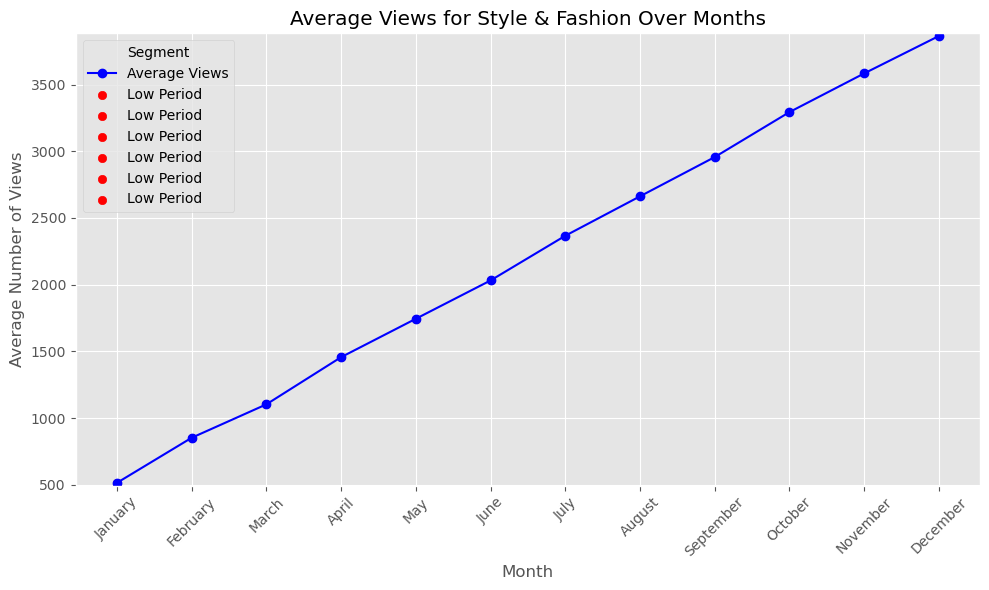

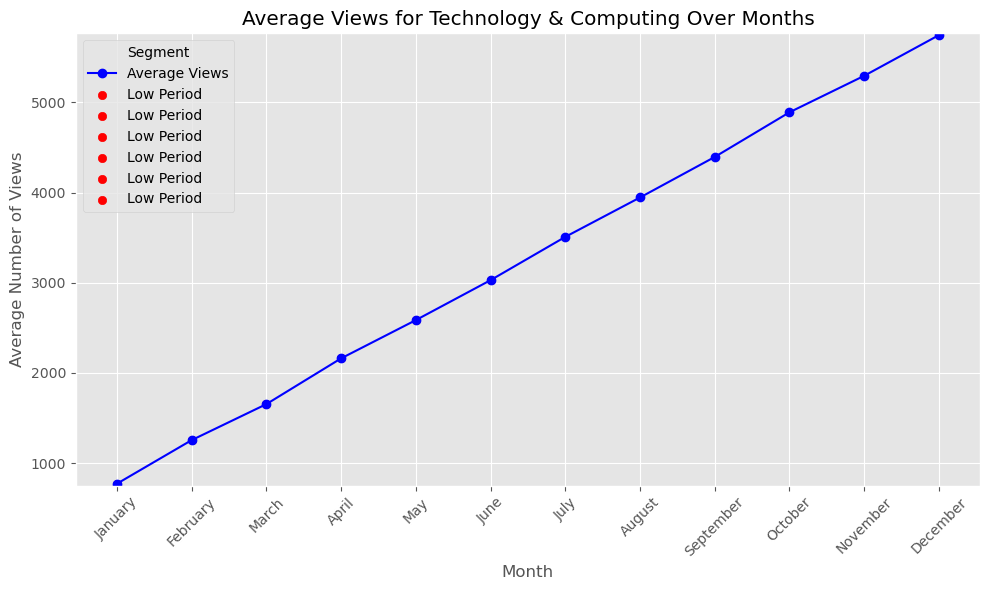

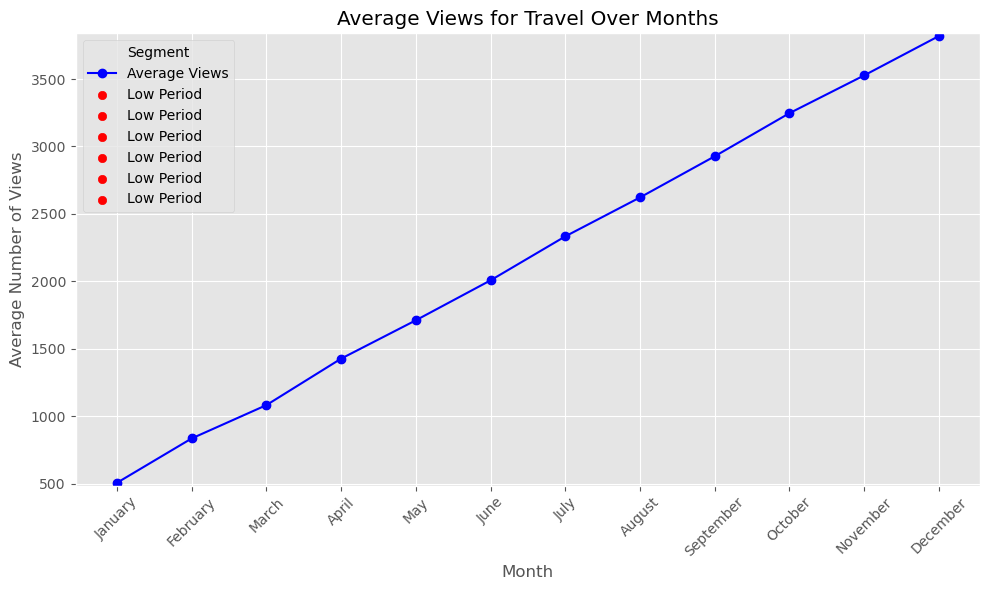

In [968]:
quartiles = final_dataset.groupby(['Segment Name'])['Number of Views'].quantile([0.25, 0.5, 0.75]).unstack()

# Identify months where specific segments fall below the lower quartile threshold
low_months_by_segment = {}
for segment in quartiles.index:
    lower_quartile = quartiles.loc[segment, 0.25]
    low_months = final_dataset[(final_dataset['Segment Name'] == segment) & (final_dataset['Number of Views'] <= lower_quartile)]
    low_months_by_segment[segment] = low_months['month'].unique()

# Print the months where specific segments fall below the threshold
for segment, low_months in low_months_by_segment.items():
    print(f"Segment: {segment}")
    print(f"Low Months: {', '.join([calendar.month_name[int(m)] for m in low_months])}")
    print("------")

# Plot the average views for each segment
average_views_by_month = final_dataset.groupby(['Segment Name', 'month'])['Number of Views'].mean().reset_index()
pivot_table = average_views_by_month.pivot(index='month', columns='Segment Name', values='Number of Views')

pivot_table.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Average Views by Segment Over Months')
plt.xlabel('Month')
plt.ylabel('Average Number of Views')
plt.legend(title='Segment')
plt.xticks(range(1, 13), calendar.month_name[1:], rotation=45)
plt.tight_layout()
plt.show()


# Create line plots highlighting low periods
for segment, periods in low_months_by_segment.items():
    plt.figure(figsize=(10, 6))
    plt.plot(pivot_table.index, pivot_table[segment], marker='o', color='blue', label='Average Views')

    for month in periods:
        plt.scatter(month, pivot_table.loc[month, segment], color='red', label='Low Period')
    
    plt.title(f'Average Views for {segment} Over Months')
    plt.xlabel('Month')
    plt.ylabel('Average Number of Views')
    plt.legend(title='Segment')
    plt.xticks(range(1, 13), calendar.month_name[1:], rotation=45)
    
    # Set y-axis range to emphasize low periods
    min_y = pivot_table[segment].min()
    max_y = pivot_table[segment].max()
    plt.ylim(min_y - 20, max_y + 20)
    
    plt.tight_layout()
    plt.show()

/var/folders/q4/xxffn3rn1mq08t7xhtm9_fbw0000gn/T/ipykernel_3159/818254351.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly= final_dataset.resample('M', on='View Date').sum()


<function matplotlib.pyplot.show(close=None, block=None)>

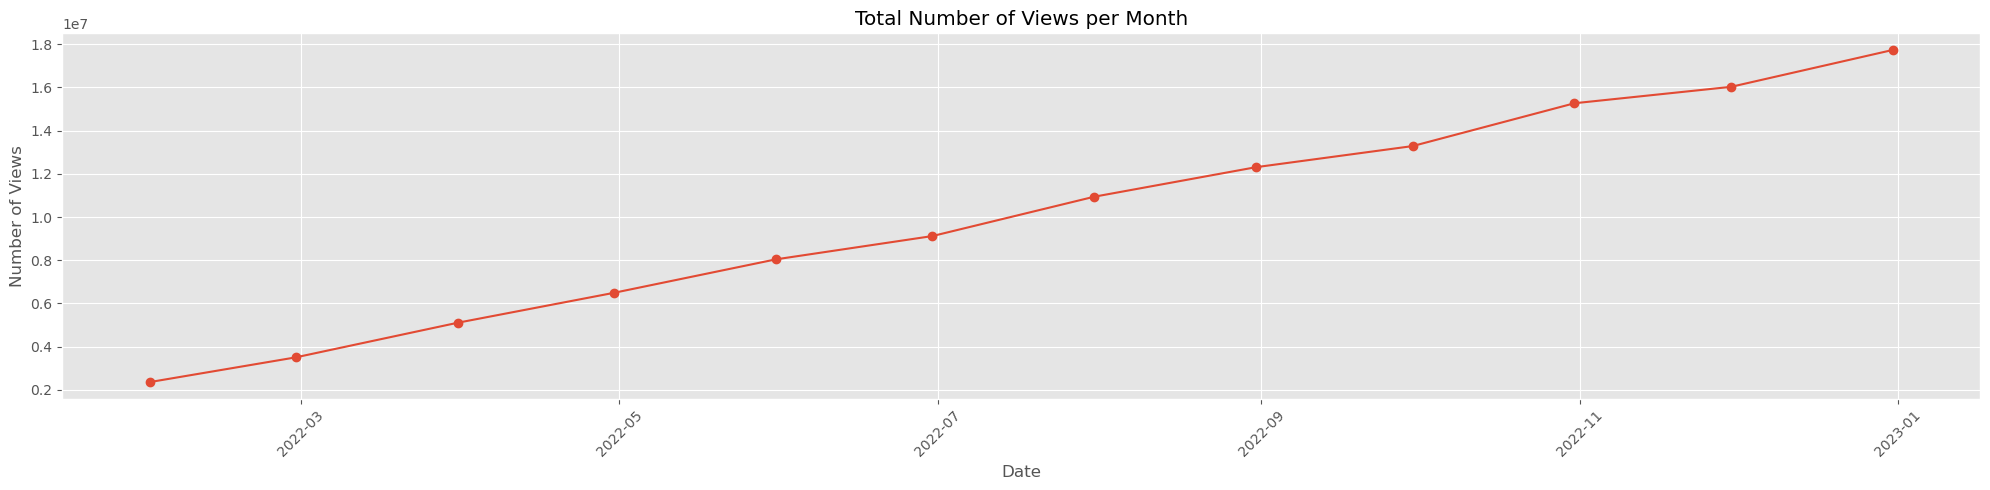

In [969]:
df_monthly= final_dataset.resample('M', on='View Date').sum()

# Plot the total number of views per day
plt.figure(figsize=(20, 5))
plt.plot(df_monthly.index, df_monthly['Number of Views'], marker='o')
plt.title('Total Number of Views per Month')
plt.xlabel('Date')
plt.ylabel('Number of Views')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show

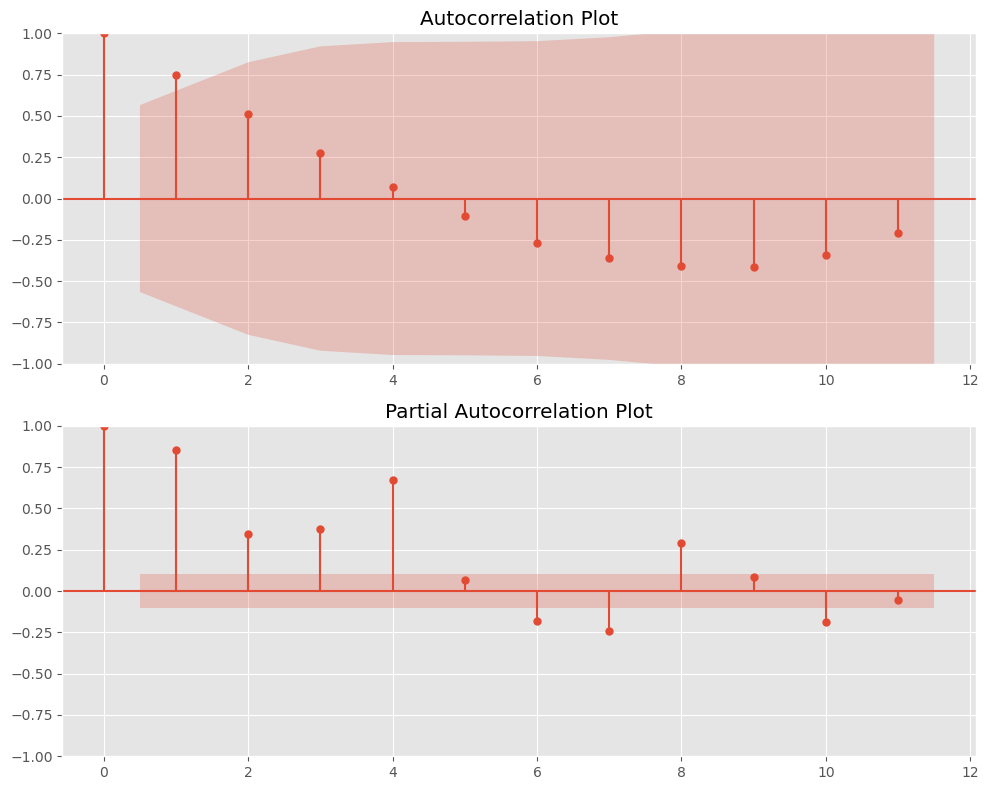

In [970]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
num_lags = len(df_monthly) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Autocorrelation plot
plot_acf(df_monthly['Number of Views'], ax=ax1, lags=num_lags)
ax1.set_title('Autocorrelation Plot')

# Partial autocorrelation plot
plot_pacf(df_daily['Number of Views'], ax=ax2, lags=num_lags)
ax2.set_title('Partial Autocorrelation Plot')

plt.tight_layout()
plt.show()

# zero jako brak korelacji  1 i -1 na silna ujemna i dodatnia , te niebiieskie jako szeregi czasowe
# Exist strong negative correlation betweeen number of views and timeslots but they are not stat. significant

# strong at lag 1, 2, 3, 4 positive in first months, stat siginificant


In [971]:
final_dataset[['Windows Device', 'Android Device', 'Mac OS X Device', 'Iphone Device',  'Other Device']].describe()

,Windows Device,Android Device,Mac OS X Device,Iphone Device,Other Device
count,95526.000000,95526.000000,95526.000000,95526.000000,95526.000000
mean,865.168980,47.649195,261.582690,60.476582,13.617277
std,1036.010017,59.390485,309.851444,74.242968,15.030967
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,141.000000,8.000000,58.000000,12.000000,3.000000
50%,445.000000,20.000000,120.000000,25.000000,8.000000
75%,1351.000000,72.000000,397.000000,92.000000,21.000000
max,10855.000000,639.000000,3352.000000,798.000000,160.000000


In [972]:
tech_computing = final_dataset[final_dataset['Segment Name'] == 'Technology & Computing']
tech_computing.head()

,ID Segment,View Date,Number of Views,Windows Device,Android Device,Mac OS X Device,Iphone Device,Other Device,Segment Name,Total Devices,month,day_of_week,day_of_month,hour,Day
0,379,2022-01-01 00:00:00,177,120,7,37,9,2,Technology & Computing,175,1,5,1,0,1
1,379,2022-01-01 01:00:00,135,92,5,28,7,1,Technology & Computing,133,1,5,1,1,1
2,379,2022-01-01 02:00:00,26,18,1,5,1,0,Technology & Computing,25,1,5,1,2,1
3,379,2022-01-01 03:00:00,159,108,6,33,8,2,Technology & Computing,157,1,5,1,3,1
4,379,2022-01-01 04:00:00,50,34,2,10,2,0,Technology & Computing,48,1,5,1,4,1


In [973]:
resampled_df = final_dataset.resample('D', on='View Date').mean()


/var/folders/q4/xxffn3rn1mq08t7xhtm9_fbw0000gn/T/ipykernel_3159/804217005.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = final_dataset.resample('D', on='View Date').mean()


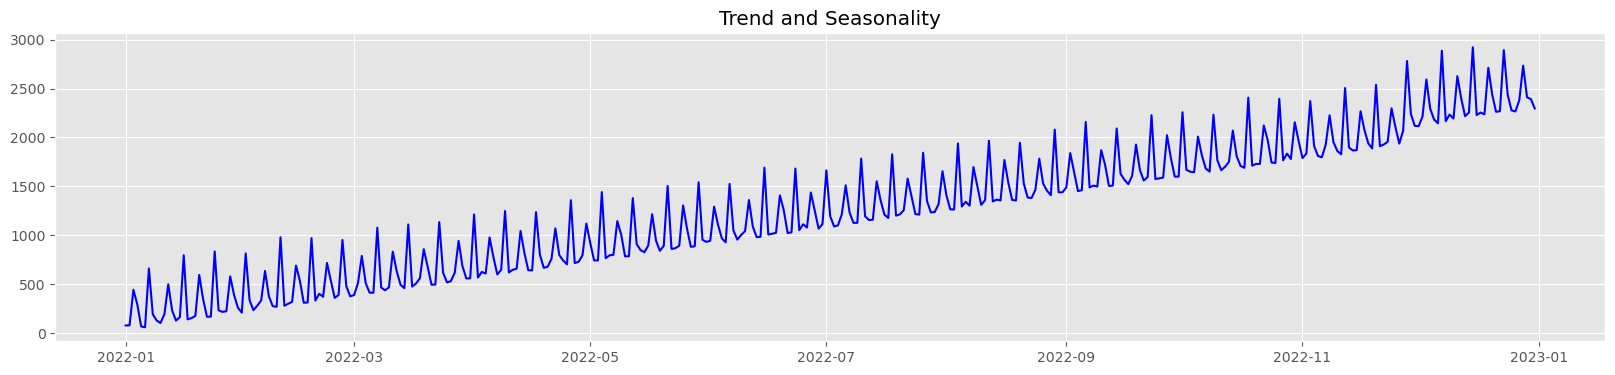

In [974]:
# plotting trend as seasonality
def plot_df(df, x, y, title="", xlabel="", ylabel="", dpi=100):
    plt.figure(figsize=(20, 4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(resampled_df, x=resampled_df.index, y=resampled_df['Number of Views'], title='Trend and Seasonality')

In [976]:
final_dataset.dtypes

ID Segment                  int64
View Date          datetime64[ns]
Number of Views             int64
Windows Device              int64
Android Device              int64
Mac OS X Device             int64
Iphone Device               int64
Other Device                int64
Segment Name               object
Total Devices               int64
month                       int64
day_of_week                 int64
day_of_month                int64
hour                        int64
Day                         int64
dtype: object

- Wyrazny trend wzrostowy ale tez sygnal okresowy.

In [977]:
final_dataset.head()
final_dataset.set_index('View Date', inplace=True) #  setting index as time_index
final_dataset.head()

,ID Segment,Number of Views,Windows Device,Android Device,Mac OS X Device,Iphone Device,Other Device,Segment Name,Total Devices,month,day_of_week,day_of_month,hour,Day
View Date,,,,,,,,,,,,,,
2022-01-01 00:00:00,379,177,120,7,37,9,2,Technology & Computing,175,1,5,1,0,1
2022-01-01 01:00:00,379,135,92,5,28,7,1,Technology & Computing,133,1,5,1,1,1
2022-01-01 02:00:00,379,26,18,1,5,1,0,Technology & Computing,25,1,5,1,2,1
2022-01-01 03:00:00,379,159,108,6,33,8,2,Technology & Computing,157,1,5,1,3,1
2022-01-01 04:00:00,379,50,34,2,10,2,0,Technology & Computing,48,1,5,1,4,1


- decomposing

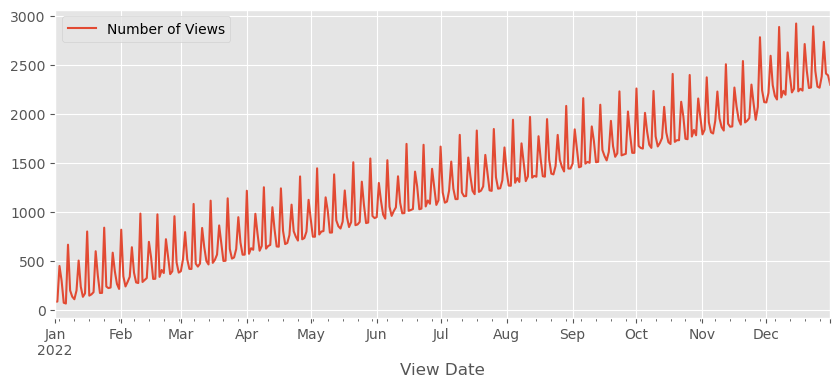

In [980]:
count_dataset = final_dataset[['Number of Views']]
data_daily = count_dataset.resample('d').mean() 
data_daily.plot()
plt.show()

In [981]:
decomposition = seasonal_decompose(data_daily['Number of Views'], model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
print(decomposition.trend)
print(decomposition.seasonal)
print(decomposition.resid)


View Date
2022-01-01            NaN
2022-01-02            NaN
2022-01-03            NaN
2022-01-04     243.406926
2022-01-05     259.871212
                 ...     
2022-12-27    2413.498214
2022-12-28    2393.329167
2022-12-29            NaN
2022-12-30            NaN
2022-12-31            NaN
Freq: D, Name: trend, Length: 365, dtype: float64
View Date
2022-01-01    0.978344
2022-01-02    1.003662
2022-01-03    0.996066
2022-01-04    1.005900
2022-01-05    0.983489
                ...   
2022-12-27    1.005900
2022-12-28    0.983489
2022-12-29    0.991486
2022-12-30    1.041053
2022-12-31    0.978344
Freq: D, Name: seasonal, Length: 365, dtype: float64
View Date
2022-01-01         NaN
2022-01-02         NaN
2022-01-03         NaN
2022-01-04    1.209015
2022-01-05    0.277977
                ...   
2022-12-27    0.980450
2022-12-28    1.161387
2022-12-29         NaN
2022-12-30         NaN
2022-12-31         NaN
Freq: D, Name: resid, Length: 365, dtype: float64


Text(0.5, 1.05, 'Views Time-Series Decomposition')

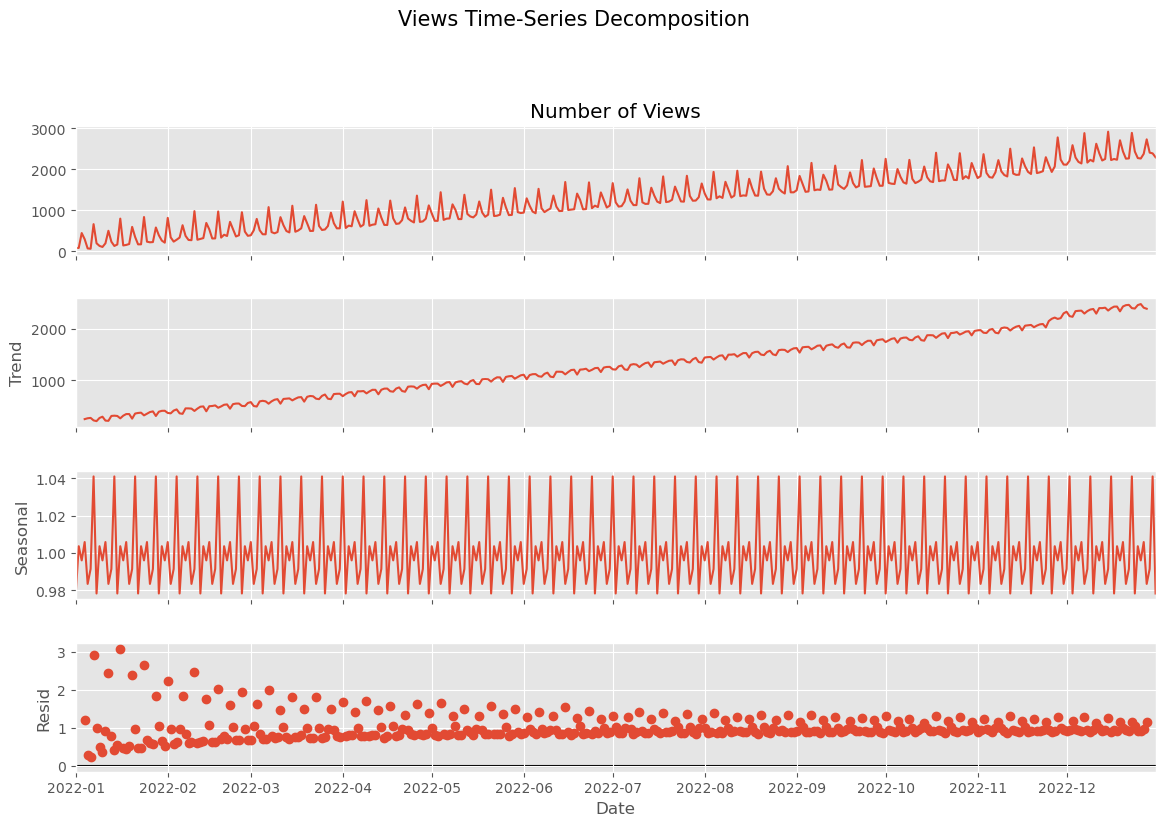

In [986]:
figure = seasonals.plot()
figure.set_figwidth(12)
figure.set_figheight(8)
plt.xlabel("Date", fontsize=12)
plt.suptitle(
    "Views Time-Series Decomposition",  # Text of title
    y=1.05,  # Position of title
    size=15,  # Size of title
)

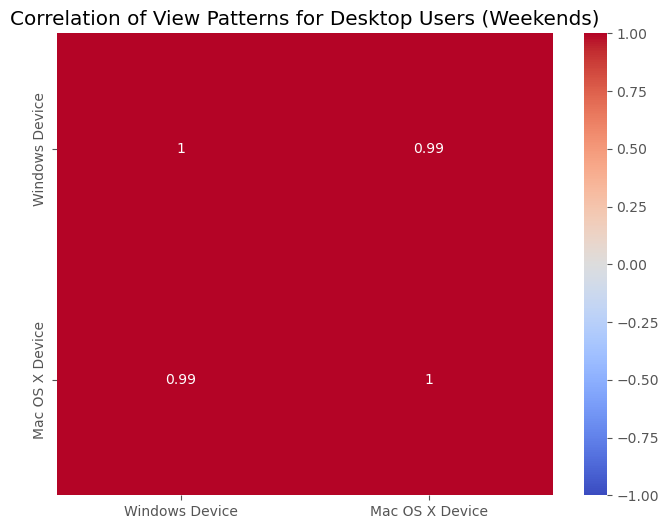

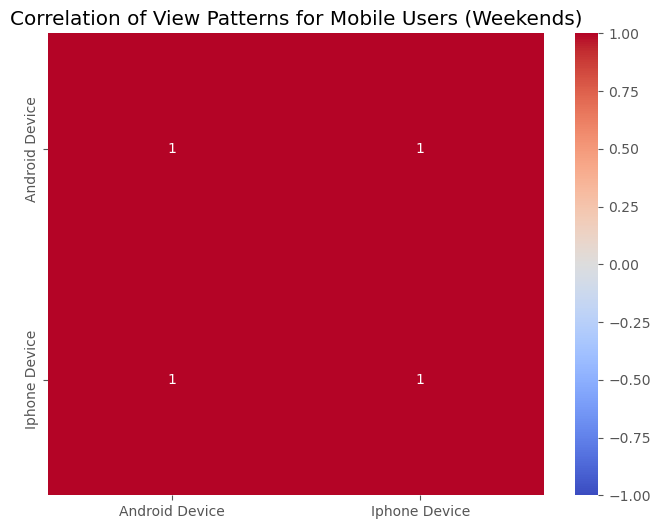

In [ ]:
desktop_corr = final_dataset[['Windows Device', 'Mac OS X Device']].corr()

# Calculates correlation coefficients between segments for Mobile users
mobile_corr =final_dataset[['Android Device', 'Iphone Device']].corr()

# Creates a heatmap for Desktop correlations
plt.figure(figsize=(8, 6))
sns.heatmap(desktop_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of View Patterns for Desktop Users (Weekends)")
plt.show()

# Creates a heatmap for Mobile correlations
plt.figure(figsize=(8, 6))
sns.heatmap(mobile_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of View Patterns for Mobile Users (Weekends)")
plt.show()

2. Positive correlation beteween desktop views and mobile views patterns, gives as also an information about a very strong linear relationship between these two variables.  

 For example, if a user from segment covers widely interesting topics such a Technology & Computing, users are more likely to engage with it regardless of device.Some user behaviors, such as checking news or social media updates during weekends, might be consistent across devices, leading to similar view patterns. Effective cross-platform promotion can result in similar viewing patterns. Users from both platforms are more likely to engage with a segment that is promoted consistently and effectively across both desktop and mobile platforms.


3. Autoregressive Integrated Moving Average (ARIMA): Suitable for data with trends and seasonality. Can handle data with differencing to make it stationary.
